In [144]:
import pandas as pd
import xarray as xr 
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=12,                   # 24 cores per node
    processes=4,                # One process per task
    memory="100GB",             # --mem
    walltime="00:30:00",        # --time
    queue="short",                # --partition
    log_directory=".",          # Logs will be saved to the current directory
)

/home1/nalex2023/.local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41083 instead
  warnings.warn(


In [145]:
import numpy as np


In [146]:
from dask.distributed import Client


cluster.scale(jobs=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:41083/status,
Dashboard: http://10.42.239.61:41083/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:40267,Workers: 0
Dashboard: http://10.42.239.61:41083/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [85]:
client.close()
cluster.close()

In [147]:
twp_manus = '/home2/nalex2023/Datasets/LSB_OUTS/met_manus_30min/'

sun_dft = pd.read_csv('/home1/nalex2023/main/LSB_main/LSB_detectionv2/Datasets/sunrise_sunset_twp.csv')

sun_dft = sun_dft.map(pd.to_datetime)

wind_speed_ds = xr.open_mfdataset(twp_manus+"*.nc").sel(time=slice('2000','2014'))




In [148]:
wind_speed_ds_new = wind_speed_ds.chunk({'time':1440*12})

## LST calculation 

$$LST = LT+\frac{TC}{60}$$

where LT is the local time 
and , TC is the Time Correction factor 

$$TC = 4(longitude - LSTM) + E_{o}T$$

Where $E_{o}T$ is the equation of time 

and , $$LSTM = 15^{o} \Delta{T}_{UTC}$$


where, $\Delta{T}_{UTC}$ is the difference between local and UTC (eg. +10 for Manus)

$$E_{o}T = 9.87\sin({2B}) - 7.53\cos({B}) - 1.5\sin({B})$$

where,

$$B = \frac{360}{365} (d - 81) $$


In [91]:
import numpy as np
import pandas as pd



delta_tutc = +7
longitude = 91


test = pd.date_range(start='2000-01',end='2002-04',freq='h').to_series()



lstm = 15 * delta_tutc


def calc_d(dt):
    start_date = pd.to_datetime(f'{dt.year}-01-01')
    diff_days = (dt - start_date).total_seconds() / (24*3600)
    return diff_days

start_date = pd.to_datetime(test.dt.year.astype(str) + '-01-01')

d_vals = (test - start_date).dt.total_seconds() / (24*3600)

dft_time = test.to_frame()

dft_time['d'] = d_vals

dft_time['B'] = (360/365) * (dft_time['d'] - 81)

dft_time['B'] = np.radians(dft_time['B'])

dft_time['ET'] = (9.97 * np.sin(dft_time['B'])) - (7.53 * np.cos(dft_time['B'])) - 1.5 * np.sin(dft_time['B'])


dft_time['TC'] = 4 * (longitude-lstm) + dft_time['ET']

dft_time['LT'] = dft_time.index + pd.Timedelta(hours=delta_tutc)

#dft_time['LT_minutes'] = dft_time['LT'].dt.total_seconds() / (60)

dft_time['LT_minutes'] = dft_time['LT'].dt.hour * 60 + dft_time['LT'].dt.minute

dft_time['LST_minutes'] = dft_time['LT_minutes']  + (dft_time['TC'] / 60 )

minute_diff = dft_time['LT_minutes'] - dft_time['LST_minutes']

timedelta_series = pd.to_timedelta(minute_diff, unit='m')

dft_time['LST'] = dft_time['LT'] - timedelta_series
#dft_time['LST']# = dft_time['LST_minutes'].apply(min_dt)

dft_time

,0,d,B,ET,TC,LT,LT_minutes,LST_minutes,LST
2000-01-01 00:00:00,2000-01-01 00:00:00,0.000000,-1.394351,-9.660245,-65.660245,2000-01-01 07:00:00,420,418.905663,2000-01-01 06:58:54.339754650
2000-01-01 01:00:00,2000-01-01 01:00:00,0.041667,-1.393633,-9.664494,-65.664494,2000-01-01 08:00:00,480,478.905592,2000-01-01 07:58:54.335506416
2000-01-01 02:00:00,2000-01-01 02:00:00,0.083333,-1.392916,-9.668737,-65.668737,2000-01-01 09:00:00,540,538.905521,2000-01-01 08:58:54.331263162
2000-01-01 03:00:00,2000-01-01 03:00:00,0.125000,-1.392199,-9.672975,-65.672975,2000-01-01 10:00:00,600,598.905450,2000-01-01 09:58:54.327024876
2000-01-01 04:00:00,2000-01-01 04:00:00,0.166667,-1.391482,-9.677208,-65.677208,2000-01-01 11:00:00,660,658.905380,2000-01-01 10:58:54.322791570
...,...,...,...,...,...,...,...,...,...
2002-03-31 20:00:00,2002-03-31 20:00:00,89.833333,0.152059,-6.160133,-62.160133,2002-04-01 03:00:00,180,178.963998,2002-04-01 02:58:57.839866992
2002-03-31 21:00:00,2002-03-31 21:00:00,89.875000,0.152776,-6.153308,-62.153308,2002-04-01 04:00:00,240,238.964112,2002-04-01 03:58:57.846691758
2002-03-31 22:00:00,2002-03-31 22:00:00,89.916667,0.153493,-6.146480,-62.146480,2002-04-01 05:00:00,300,298.964225,2002-04-01 04:58:57.853519693
2002-03-31 23:00:00,2002-03-31 23:00:00,89.958333,0.154211,-6.139649,-62.139649,2002-04-01 06:00:00,360,358.964339,2002-04-01 05:58:57.860350788


In [ ]:
import numpy as np
import pandas as pd

# Constants
delta_tutc = +7       # Local time offset from UTC
longitude = 91        # Longitude in degrees

# Create a time series at hourly intervals
test = pd.date_range(start='2000-01', end='2002-04', freq='h').to_series()

# Standard calculations you had for solar corrections (kept as is)
lstm = 15 * delta_tutc

def calc_d(dt):
    start_date = pd.to_datetime(f'{dt.year}-01-01')
    diff_days = (dt - start_date).total_seconds() / (24*3600)
    return diff_days

start_date = pd.to_datetime(test.dt.year.astype(str) + '-01-01')

d_vals = (test - start_date).dt.total_seconds() / (24*3600)

dft_time = test.to_frame()
dft_time['d'] = d_vals

# Solar time correction calculations (kept for reference)
dft_time['B'] = (360/365) * (dft_time['d'] - 81)
dft_time['B'] = np.radians(dft_time['B'])
dft_time['ET'] = (9.97 * np.sin(dft_time['B'])) - (7.53 * np.cos(dft_time['B'])) - 1.5 * np.sin(dft_time['B'])
dft_time['TC'] = 4 * (longitude-lstm) + dft_time['ET']

# Calculate Local Time (LT)
dft_time['LT'] = dft_time.index + pd.Timedelta(hours=delta_tutc)
dft_time['LT_minutes'] = dft_time['LT'].dt.hour * 60 + dft_time['LT'].dt.minute

# -- START: Sidereal Time Calculation --
# Function to calculate GMST (Greenwich Mean Sidereal Time)
def calc_gmst(dt):
    # Calculate Julian Date
    Y = dt.year
    M = dt.month
    D = dt.day + dt.hour/24 + dt.minute/(24*60) + dt.second/(24*3600)
    if M <= 2:
        Y -= 1
        M += 12
    A = int(Y / 100)
    B = 2 - A + int(A / 4)
    JD = int(365.25 * (Y + 4716)) + int(30.6001 * (M + 1)) + D + B - 1524.5

    # Calculate Julian centuries since J2000.0
    T = (JD - 2451545.0) / 36525.0

    # GMST in seconds
    GMST_sec = 24110.54841 + 8640184.812866 * T + 0.093104 * T**2 - 6.2e-6 * T**3
    # Add the time of day in seconds
    UT_sec = dt.hour * 3600 + dt.minute * 60 + dt.second
    GMST_sec += 1.00273790935 * UT_sec
    # Normalize GMST to [0,86400)
    GMST_sec = GMST_sec % 86400
    # Convert GMST to hours
    GMST_hr = GMST_sec / 3600
    return GMST_hr

# Apply GMST calculation to each UTC datetime
dft_time['GMST_hr'] = dft_time.index.to_series().apply(calc_gmst)

# Add longitude correction: longitude in degrees / 15 = hours
#dft_time['LST_hr'] = (dft_time['GMST_hr'] + longitude/15.0) % 24

# -- END: Sidereal Time Calculation --

# Optional: Convert LST_hr back to datetime for easier reading.
dft_time['LST'] = pd.to_datetime(dft_time.index.date) + pd.to_timedelta(dft_time['LST_hr'], unit='h')

# Now dft_time contains a correct LST calculation using longitude.

# You can verify that LST changes significantly for different longitudes by changing the longitude variable.

,0,d,B,ET,TC,LT,LT_minutes,GMST_hr,LST_hr,LST
2000-01-01 00:00:00,2000-01-01 00:00:00,0.000000,-1.394351,-9.660245,-33.660245,2000-01-01 07:00:00,420,6.664520,13.264520,2000-01-01 13:15:52.270726046
2000-01-01 01:00:00,2000-01-01 01:00:00,0.041667,-1.393633,-9.664494,-33.664494,2000-01-01 08:00:00,480,7.669995,14.269995,2000-01-01 14:16:11.983673330
2000-01-01 02:00:00,2000-01-01 02:00:00,0.083333,-1.392916,-9.668737,-33.668737,2000-01-01 09:00:00,540,8.675471,15.275471,2000-01-01 15:16:31.696620729
2000-01-01 03:00:00,2000-01-01 03:00:00,0.125000,-1.392199,-9.672975,-33.672975,2000-01-01 10:00:00,600,9.680947,16.280947,2000-01-01 16:16:51.409568013
2000-01-01 04:00:00,2000-01-01 04:00:00,0.166667,-1.391482,-9.677208,-33.677208,2000-01-01 11:00:00,660,10.686423,17.286423,2000-01-01 17:17:11.122515301
...,...,...,...,...,...,...,...,...,...,...
2002-03-31 20:00:00,2002-03-31 20:00:00,89.833333,0.152059,-6.160133,-30.160133,2002-04-01 03:00:00,180,8.656092,15.256092,2002-03-31 15:15:21.931404652
2002-03-31 21:00:00,2002-03-31 21:00:00,89.875000,0.152776,-6.153308,-30.153308,2002-04-01 04:00:00,240,9.661568,16.261568,2002-03-31 16:15:41.644351944
2002-03-31 22:00:00,2002-03-31 22:00:00,89.916667,0.153493,-6.146480,-30.146480,2002-04-01 05:00:00,300,10.667044,17.267044,2002-03-31 17:16:01.357299235
2002-03-31 23:00:00,2002-03-31 23:00:00,89.958333,0.154211,-6.139649,-30.139649,2002-04-01 06:00:00,360,11.672520,18.272520,2002-03-31 18:16:21.070246638


In [19]:
112/15



7.466666666666667

In [149]:
sel_date = '2012-01-04'
wind_speed_data = wind_speed_ds_new.roll(time=10*2)
#test_sel = sun_dft.set_index('date').loc[wind_speed_data.isel(time=0).time.dt.date.values.astype(str)]
test_sel = sun_dft.set_index('date').loc[sel_date]
local_data = test_sel+pd.Timedelta(hours=10)

In [150]:
sun_dft

,date,sunrise(UTC),sunset(UTC)
0,2000-01-01,1999-12-31 20:06:38.444661376,2000-01-01 08:20:39.908245248
1,2000-01-02,2000-01-01 20:07:07.708542720,2000-01-02 08:21:07.342338560
2,2000-01-03,2000-01-02 20:07:36.726734976,2000-01-03 08:21:34.371180672
3,2000-01-04,2000-01-03 20:08:05.464764288,2000-01-04 08:22:00.962267264
4,2000-01-05,2000-01-04 20:08:33.888653824,2000-01-05 08:22:27.083652992
...,...,...,...
5475,2014-12-28,2014-12-27 20:04:48.841008640,2014-12-28 08:18:55.510619648
5476,2014-12-29,2014-12-28 20:05:18.684226048,2014-12-29 08:19:24.142050560
5477,2014-12-30,2014-12-29 20:05:48.366424320,2014-12-30 08:19:52.445321472
5478,2014-12-31,2014-12-30 20:06:17.856284672,2014-12-31 08:20:20.390078464


In [156]:

# filter 1 application

import numpy as np

wind_speed_data['sunrise_utc'] = xr.DataArray(sun_dft['sunrise(UTC)'].values,dims=('day'),
                      coords={'day':sun_dft['date']},name='sunrise_utc')


wind_speed_data['sunset_utc'] = xr.DataArray(sun_dft['sunset(UTC)'].values,dims=('day'),
                      coords={'day':sun_dft['date']},name='sunset_utc')



test_day = wind_speed_data['day'][0].dt.date.astype(str).values

type(test_day)
test_ds = wind_speed_data.sel(time=test_day)

sunrise = wind_speed_data['sunrise_utc'].isel(day=0).values +pd.Timedelta(hours=10)

sunrise_range = pd.date_range(start = sunrise+pd.Timedelta(hours=1),
                              end=sunrise + pd.Timedelta(hours=7),freq='30min').round('30min')


post_sunset_data = wind_speed_data.sel(time=sunrise_range).compute()

diff_data = post_sunset_data['wspd_arith_mean'].diff(dim='time').reindex(time=post_sunset_data['time']).compute() 

lsb_ws_onset = post_sunset_data['wspd_arith_mean'][diff_data > 1.5]

if len(lsb_ws_onset <= 0):
    output = lsb_ws_onset.time[0].dt.time.astype(str).values

else : 
    output = np.nan

output


array('09:00:00', dtype='<U8')

In [166]:
start = '2012-01-01'
end = '2012-12-31'
computed_wind_speed_data = wind_speed_data.sel(time=slice(start,end)).compute()

In [170]:

def detect_lsb_ws_onset(wind_speed_data: xr.Dataset, day: pd.Timestamp) -> str:
    test_day = str(pd.to_datetime(day).date())
    try:
        sunrise = wind_speed_data['sunrise_utc'].sel(day=test_day).values + pd.Timedelta(hours=10)
    except KeyError:
        return np.nan
    sunrise_range = pd.date_range(start=sunrise+pd.Timedelta(hours=1),end=sunrise+pd.Timedelta(hours=7),freq="30min").round("30min")
    post_sunrise_data = wind_speed_data.sel(time=sunrise_range)
    if post_sunrise_data.time.size == 0:
        return np.nan
    diff_data = post_sunrise_data["wspd_arith_mean"].diff(dim="time").reindex(time=post_sunrise_data["time"])
    lsb_ws_onset = post_sunrise_data["wspd_arith_mean"][diff_data > 1.5]
    return lsb_ws_onset.time[0].dt.time.astype(str).values if lsb_ws_onset.size > 0 else np.nan

filter_1_results = pd.date_range(start=start,end=end,freq='1D').to_series()


test_result_dft = pd.DataFrame(filter_1_results,columns=['datetime'])
test_result_dft['filter2']= filter_1_results.apply(lambda d: detect_lsb_ws_onset(computed_wind_speed_data,d))


In [171]:
test_result_dft['filter2_result'] = ~test_result_dft['filter2'].isna()


In [174]:
test_result_dft

,datetime,filter2,filter2_result
2012-01-01,2012-01-01,11:00:00,True
2012-01-02,2012-01-02,NaN,False
2012-01-03,2012-01-03,NaN,False
2012-01-04,2012-01-04,08:30:00,True
2012-01-05,2012-01-05,08:30:00,True
...,...,...,...
2012-12-27,2012-12-27,09:00:00,True
2012-12-28,2012-12-28,09:30:00,True
2012-12-29,2012-12-29,12:00:00,True
2012-12-30,2012-12-30,13:00:00,True


In [175]:
### Filter 3 Playground 


def detect_lsb_wd_condition(wind_speed_data: xr.Dataset, day: pd.Timestamp) -> str:
    min_wd = 0
    max_wd = 180
    test_day = str(pd.to_datetime(day).date())
    try:
        sunrise = wind_speed_data['sunrise_utc'].sel(day=test_day).values + pd.Timedelta(hours=10)
    except KeyError:
        return np.nan
    sunrise_range = pd.date_range(start=sunrise+pd.Timedelta(hours=1),end=sunrise+pd.Timedelta(hours=7),freq="30min").round("30min")
    post_sunrise_data = wind_speed_data.sel(time=sunrise_range)
    if post_sunrise_data.time.size == 0:
        return np.nan
    wd_mask = (post_sunrise_data["wdir_vec_mean"] >= min_wd) & (post_sunrise_data["wdir_vec_mean"] <= max_wd)
    lsb_ws_onset = post_sunrise_data["wdir_vec_mean"][wd_mask]
    return lsb_ws_onset.time[0].dt.time.astype(str).values if lsb_ws_onset.size > 0 else np.nan

test_result_dft['filter3']= filter_1_results.apply(lambda d: detect_lsb_wd_condition(computed_wind_speed_data,d))


In [176]:
test_result_dft['filter3_result'] = ~test_result_dft['filter3'].isna()


In [177]:
test_result_dft


,datetime,filter2,filter2_result,filter3,filter3_result
2012-01-01,2012-01-01,11:00:00,True,07:00:00,True
2012-01-02,2012-01-02,NaN,False,NaN,False
2012-01-03,2012-01-03,NaN,False,07:30:00,True
2012-01-04,2012-01-04,08:30:00,True,11:00:00,True
2012-01-05,2012-01-05,08:30:00,True,NaN,False
...,...,...,...,...,...
2012-12-27,2012-12-27,09:00:00,True,NaN,False
2012-12-28,2012-12-28,09:30:00,True,10:00:00,True
2012-12-29,2012-12-29,12:00:00,True,07:30:00,True
2012-12-30,2012-12-30,13:00:00,True,08:30:00,True


In [231]:
# filter 4 previous wind direction or wind speed


def filter4_prev_cond(wind_speed_data: xr.Dataset,result_dft:pd.Series) -> bool:
    input_data = result_dft
    time_onset = input_data['datetime'].strftime("%Y-%m-%d") + ' ' +input_data['filter2']
    test_time = pd.to_datetime(time_onset) - pd.Timedelta(minutes=30)

    wspd_diff = wind_speed_data['wspd_arith_mean'].diff(dim='time')

    wd_prev = wind_speed_data['wspd_vec_mean'].sel(time=test_time)
    ws_diff_prev = wspd_diff.sel(time=test_time)
    
    if ws_diff_prev < 1.5:
        condition1 = True
    else :
        condition1 = False

    if (wd_prev > 181):
        condition2 = True
    else:
        condition2 = False

    return (condition1 or condition2)


test_result_dft_notna = test_result_dft[test_result_dft['filter2'].notna()]


test_result_dft["filter4"] = test_result_dft_notna.apply(lambda row: filter4_prev_cond(computed_wind_speed_data, row), axis=1).reindex(test_result_dft.index,
                                                                                                                                                    fill_value=np.nan)



"""
filter_4_input_data = test_result_dft[test_result_dft['filter2'].notna()]

test_time = filter_4_input_data.iloc[10,:]['datetime'].strftime("%Y-%m-%d") + ' ' +filter_4_input_data.iloc[10,:]['filter2']

computed_wind_speed_data_ws_diff = computed_wind_speed_data['wspd_arith_mean'].diff(dim='time')

test_time = pd.to_datetime(test_time) - pd.Timedelta(minutes=30)

ws_diff_prev = computed_wind_speed_data_ws_diff.sel(time=test_time)

wd_prev = computed_wind_speed_data['wdir_vec_mean'].sel(time=test_time)

if ws_diff_prev < 1.5:
    condition1 = True
else :
    condition1 = False

if (wd_prev > 181):
    condition2 = True
else:
    condition2 = False


condition = condition1 or condition2


condition
"""
test_result_dft


,datetime,filter2,filter2_result,filter3,filter3_result,filter4
2012-01-01,2012-01-01,11:00:00,True,07:00:00,True,True
2012-01-02,2012-01-02,NaN,False,NaN,False,NaN
2012-01-03,2012-01-03,NaN,False,07:30:00,True,NaN
2012-01-04,2012-01-04,08:30:00,True,11:00:00,True,True
2012-01-05,2012-01-05,08:30:00,True,NaN,False,True
...,...,...,...,...,...,...
2012-12-27,2012-12-27,09:00:00,True,NaN,False,True
2012-12-28,2012-12-28,09:30:00,True,10:00:00,True,True
2012-12-29,2012-12-29,12:00:00,True,07:30:00,True,True
2012-12-30,2012-12-30,13:00:00,True,08:30:00,True,True


In [237]:
def detect_lsb_ws_cess(wind_speed_data: xr.Dataset, day: pd.Series) -> bool:
    test_day = str(pd.to_datetime(day).date())
    try:
        sunset = wind_speed_data['sunset_utc'].sel(day=test_day).values + pd.Timedelta(hours=10)
    except KeyError:
        return np.nan
    sunset_range = pd.date_range(start=sunset+pd.Timedelta(hours=-1),end=sunset+pd.Timedelta(hours=+5),freq="30min").round("30min")
    post_sunset_data = wind_speed_data.sel(time=sunset_range)
    if post_sunset_data.time.size == 0:
        return np.nan
    max_sea = post_sunset_data["wspd_arith_mean"].max()
    time_max = post_sunset_data["wspd_arith_mean"].idxmax()
    return time_max.dt.time.astype(str).values if max_sea < 1.5 else np.nan

test_result_dft['filter6']= filter_1_results.apply(lambda d: detect_lsb_ws_cess(computed_wind_speed_data,d))



In [238]:
test_result_dft['filter6_result'] = ~test_result_dft['filter6'].isna()

test_result_dft

,datetime,filter2,filter2_result,filter3,filter3_result,filter4,filter6,filter6_result
2012-01-01,2012-01-01,11:00:00,True,07:00:00,True,True,NaN,False
2012-01-02,2012-01-02,NaN,False,NaN,False,NaN,NaN,False
2012-01-03,2012-01-03,NaN,False,07:30:00,True,NaN,NaN,False
2012-01-04,2012-01-04,08:30:00,True,11:00:00,True,True,NaN,False
2012-01-05,2012-01-05,08:30:00,True,NaN,False,True,NaN,False
...,...,...,...,...,...,...,...,...
2012-12-27,2012-12-27,09:00:00,True,NaN,False,True,NaN,False
2012-12-28,2012-12-28,09:30:00,True,10:00:00,True,True,NaN,False
2012-12-29,2012-12-29,12:00:00,True,07:30:00,True,True,NaN,False
2012-12-30,2012-12-30,13:00:00,True,08:30:00,True,True,NaN,False


In [247]:
def syno_filter7(wind_speed_data: xr.Dataset,result_dft:pd.Series):
    input_data = result_dft
    time_onset = input_data['datetime'].strftime("%Y-%m-%d") + ' ' +input_data['filter6']
    time_cess = input_data['datetime'].strftime("%Y-%m-%d") + ' ' +input_data['filter6']

    lsb_period = wind_speed_data['wspd_arith_mean'].sel(time=slice(time_onset,time_cess))

    max_wspd = lsb_period.max()

    time_max = lsb_period.idxmax()
    return False if max_wspd > 10 else True



test_result_dft_notna = test_result_dft[test_result_dft['filter6'].notna()]


test_result_dft['filter7'] = test_result_dft_notna.apply(lambda row: syno_filter7(computed_wind_speed_data, row), axis=1).reindex(test_result_dft.index,
                                                                                                                                                    fill_value=np.nan)


test_result_dft

,datetime,filter2,filter2_result,filter3,filter3_result,filter4,filter6,filter6_result,filter7
2012-01-01,2012-01-01,11:00:00,True,07:00:00,True,True,NaN,False,NaN
2012-01-02,2012-01-02,NaN,False,NaN,False,NaN,NaN,False,NaN
2012-01-03,2012-01-03,NaN,False,07:30:00,True,NaN,NaN,False,NaN
2012-01-04,2012-01-04,08:30:00,True,11:00:00,True,True,NaN,False,NaN
2012-01-05,2012-01-05,08:30:00,True,NaN,False,True,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...
2012-12-27,2012-12-27,09:00:00,True,NaN,False,True,NaN,False,NaN
2012-12-28,2012-12-28,09:30:00,True,10:00:00,True,True,NaN,False,NaN
2012-12-29,2012-12-29,12:00:00,True,07:30:00,True,True,NaN,False,NaN
2012-12-30,2012-12-30,13:00:00,True,08:30:00,True,True,NaN,False,NaN


In [253]:
test_result_dft['lsb_condition_phase1'] = ((test_result_dft['filter2_result']) & (test_result_dft['filter3_result']) & (test_result_dft['filter4']))

test_result_dft_final = test_result_dft[test_result_dft['lsb_condition_phase1'] == True]

test_result_dft_final

,datetime,filter2,filter2_result,filter3,filter3_result,filter4,filter6,filter6_result,filter7,lsb_condition_phase1
2012-01-01,2012-01-01,11:00:00,True,07:00:00,True,True,NaN,False,NaN,True
2012-01-04,2012-01-04,08:30:00,True,11:00:00,True,True,NaN,False,NaN,True
2012-01-06,2012-01-06,08:30:00,True,08:00:00,True,True,NaN,False,NaN,True
2012-01-13,2012-01-13,10:00:00,True,07:00:00,True,True,NaN,False,NaN,True
2012-01-28,2012-01-28,08:30:00,True,08:00:00,True,True,NaN,False,NaN,True
2012-01-29,2012-01-29,10:00:00,True,13:00:00,True,True,NaN,False,NaN,True
2012-02-09,2012-02-09,12:00:00,True,08:30:00,True,True,NaN,False,NaN,True
2012-02-11,2012-02-11,09:30:00,True,08:30:00,True,True,NaN,False,NaN,True
2012-02-12,2012-02-12,10:00:00,True,08:00:00,True,True,NaN,False,NaN,True
2012-03-17,2012-03-17,08:30:00,True,07:30:00,True,True,17:30:00,True,True,True


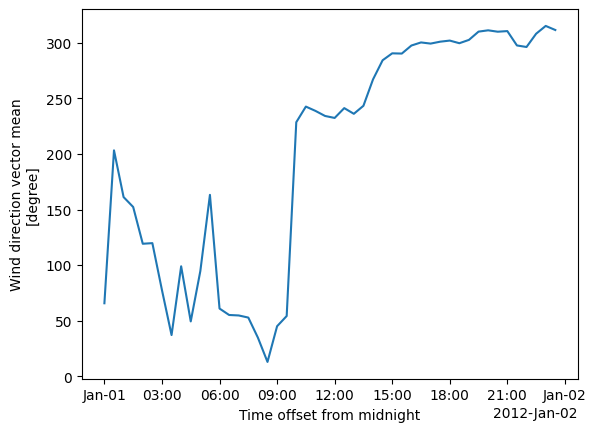

In [263]:
final_data = computed_wind_speed_data.sel(time=test_result_dft_final['datetime'].iloc[0].strftime("%Y-%m-%d"))

final_data['wdir_vec_mean'].plot()

In [143]:

day = '2012-01-01'
time = test_result_dft.loc[day]['filter2']
datetime = f'{day} {time}'
pd_time = pd.to_datetime(datetime)

sel_data = wind_speed_data.sel(time=slice(pd_time-pd.Timedelta(hours=1),
                                          pd_time))

sel_data


<xarray.Dataset> Size: 132kB
Dimensions:               (time: 3, day: 5480)
Coordinates:
  * time                  (time) datetime64[ns] 24B 2012-01-01T10:00:00 ... 2...
  * day                   (day) datetime64[ns] 44kB 2000-01-01 ... 2015-01-01
Data variables:
    atmos_pressure        (time) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    temp_mean             (time) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    rh_mean               (time) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    wspd_arith_mean       (time) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    wspd_vec_mean         (time) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    wdir_vec_mean         (time) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    org_precip_rate_mean  (time) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    sunrise_utc           (day) datetime64[ns] 44kB 1999-12-31T20:06:38.44466...
    sunset_utc            (day) datetime64[ns] 44kB 2000-01-01T08:20:39.90824...
Attributes: (12/30)
    command_line:                met_ingest -s twp -f C1 -R
    process_version:             ingest-met-4.28-0.el6
    dod_version:                 met-b1-8.1
    input_source:                /data/home/gervais/prod/jobs/0742/collection...
    site_id:                     twp
    platform_id:                 met
    ...                          ...
    qc_bit_2_assessment:         Bad
    qc_bit_3_description:        Value is greater than the valid_max.
    qc_bit_3_assessment:         Bad
    qc_bit_4_description:        Difference between current and previous valu...
    qc_bit_4_assessment:         Indeterminate
    history:                     created by user gervais on machine amber at ...

In [82]:
test_result_dft['filter4_result'] = ~test_result_dft['filter4'].isna()

test_result_dft

,datetime,filter1,filter1_result,filter2,filter2_result,filter3,filter3_result,filter4,filter4_result
2012-01-01,2012-01-01,11:00:00,True,07:00:00,True,NaN,False,17:30:00,True
2012-01-02,2012-01-02,NaN,False,NaN,False,NaN,False,23:00:00,True
2012-01-03,2012-01-03,NaN,False,07:30:00,True,NaN,False,18:00:00,True
2012-01-04,2012-01-04,08:30:00,True,11:00:00,True,NaN,False,17:30:00,True
2012-01-05,2012-01-05,08:30:00,True,NaN,False,NaN,False,17:30:00,True
...,...,...,...,...,...,...,...,...,...
2012-12-27,2012-12-27,09:00:00,True,NaN,False,NaN,False,17:30:00,True
2012-12-28,2012-12-28,09:30:00,True,10:00:00,True,NaN,False,17:30:00,True
2012-12-29,2012-12-29,12:00:00,True,07:30:00,True,NaN,False,17:30:00,True
2012-12-30,2012-12-30,13:00:00,True,08:30:00,True,NaN,False,17:30:00,True


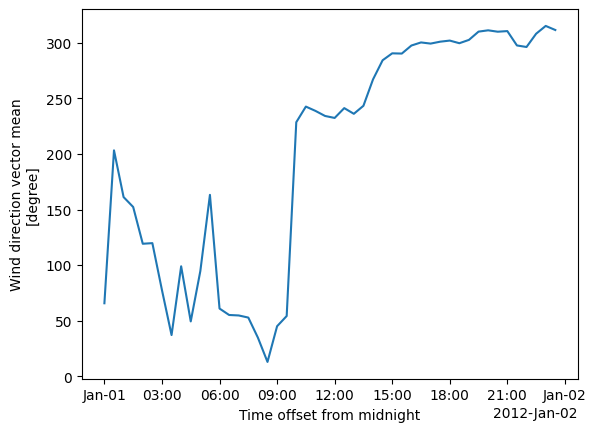

In [130]:
computed_wind_speed_data['wdir_vec_mean'].sel(time='2012-01-01').plot()



#computed_wind_speed_data['wspd_arith_mean'].sel(time='2012-01-01').plot()



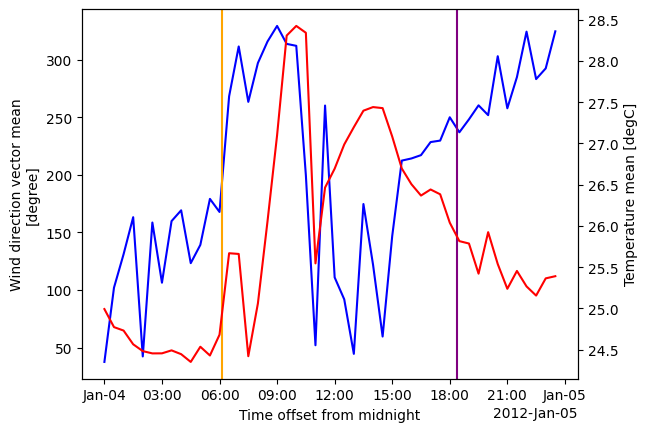

In [40]:
import matplotlib.pyplot as plt 


fig,ax = plt.subplots()
sample_day = wind_speed_data.sel(time=sel_date)

sample_day['wdir_vec_mean'].plot(ax=ax,color='blue')
ax2 = ax.twinx()
sample_day['temp_mean'].plot(ax=ax2,color='red')

ax.axvline(x=local_data['sunrise(UTC)'],color='orange')
ax.axvline(x=local_data['sunset(UTC)'],color='purple')

In [ ]:
wspd_change = wind_speed_data['wspd_arith_mean'].sel(time=sel_date).diff(dim='time').compute()
wsp_cr_times = wspd_change[wspd_change > 1.5].time.values

In [21]:
wsp_cr_times

array(['2012-01-04T07:00:00.000000000', '2012-01-04T08:30:00.000000000',
       '2012-01-04T09:30:00.000000000', '2012-01-04T10:00:00.000000000'],
      dtype='datetime64[ns]')

Text(0.5, 1.0, 'Wind Rose for 08-16h LST')

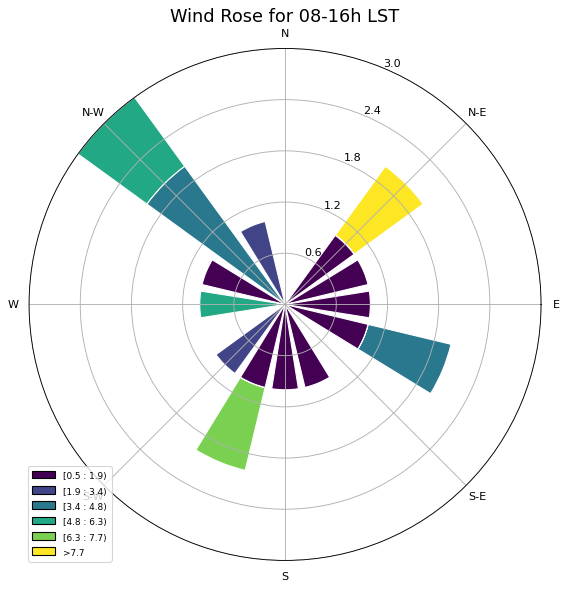

In [22]:
import windrose

windrose_ax = windrose.WindroseAxes.from_ax()

sample_day = sample_day.assign_coords(
    time_of_day=('time', [t.strftime('%H:%M') for t in pd.to_datetime(sample_day['time'].values)])
)

sel_times = sample_day.where(
    (sample_day['time_of_day'] >= '08:00') & (sample_day['time_of_day'] <= '16:00'),
    drop=True
)



wd = sel_times['wdir_vec_mean'].values
ws = sel_times['wspd_arith_mean'].values

windrose_ax.bar(wd, ws, opening=0.8, edgecolor='white')

windrose_ax.set_legend()    

# set title
windrose_ax.set_title('Wind Rose for 08-16h LST', fontsize=16)

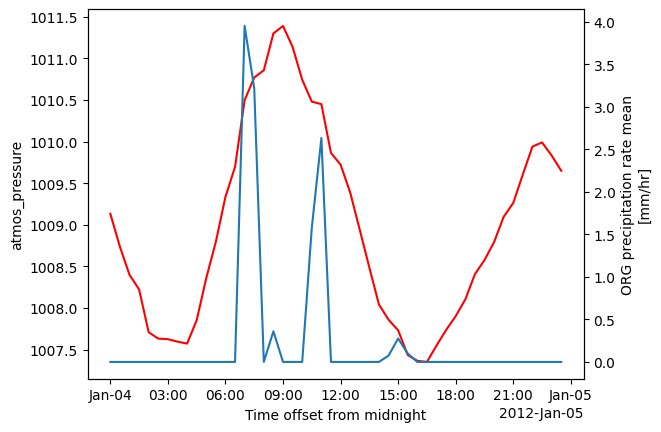

In [234]:

test_inr = xr.open_dataset('/home2/nalex2023/Datasets/interpsonde_manus/2001_MANUS_INTERPSONDEv2.nc')

test_inr#.sel(time=slice('2000-01-01','2000-01-02'))

<xarray.Dataset> Size: 38MB
Dimensions:   (time: 4776, height: 332)
Coordinates:
  * height    (height) float32 1kB 0.004 0.024 0.044 0.064 ... 39.5 40.0 40.5
  * time      (time) datetime64[ns] 38kB 2001-04-05 ... 2001-12-31T23:00:00
Data variables:
    bar_pres  (time, height) float32 6MB ...
    temp      (time, height) float32 6MB ...
    dp        (time, height) float32 6MB ...
    rh        (time, height) float32 6MB ...
    u_wind    (time, height) float32 6MB ...
    v_wind    (time, height) float32 6MB ...
Attributes: (12/13)
    command_line:          idl -D 0 -R -n interpolatedsonde -s twp -f C1 -b 2...
    Conventions:           ARM-1.1
    process_version:       vap-interpolatedsonde-6.6-0.el6
    input_datastreams:     twpgriddedsondeC1.c0 : 2.2 : 20010403.000030-20010...
    dod_version:           interpolatedsonde-c1-4.0
    site_id:               twp
    ...                    ...
    facility_id:           C1
    data_level:            c1
    location_description:  Tropical Western Pacific (TWP), Manus Island, Papu...
    datastream:            twpinterpolatedsondeC1.c1
    doi:                   10.5439/1095316
    history:               created by user ttoto on machine chalk at 2016-05-...

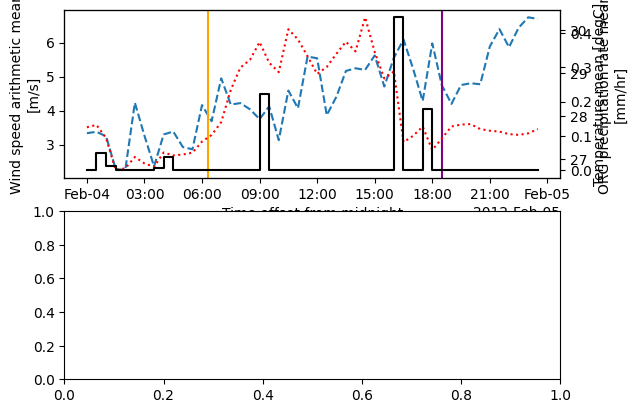

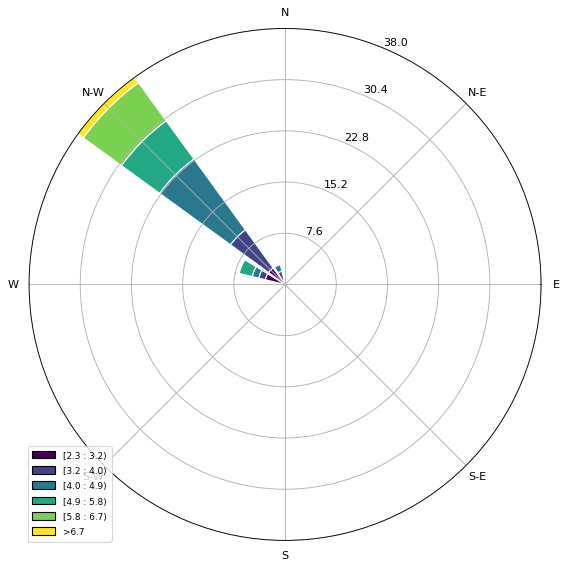

In [ ]:
fig,ax = plt.subplots(2,1)


ax1 = ax[0]
ax_other = ax[1]

sel_date='2012-02-04'
sample_day = wind_speed_data.sel(time=sel_date)
wind_speed_data = wind_speed_ds_new.roll(time=10*2)
#test_sel = sun_dft.set_index('date').loc[wind_speed_data.isel(time=0).time.dt.date.values.astype(str)]
test_sel = sun_dft.set_index('date').loc[sel_date]
local_data = test_sel+pd.Timedelta(hours=10)


sample_day['wspd_arith_mean'].plot(ax=ax1,linestyle='dashed')

ax2 = ax1.twinx()

sample_day['temp_mean'].plot(ax=ax2,color='red',linestyle='dotted')

# add another axis for bar plots
ax3 = ax1.twinx()

#sample_day['org_precip_rate_mean'].plot(ax=ax3,color='blue',linestyle='dashdot') # convert to bar

sample_day['org_precip_rate_mean'].plot.step(color='black')


ax1.axvline(x=local_data['sunrise(UTC)'],color='orange')
ax1.axvline(x=local_data['sunset(UTC)'],color='purple')

wind_axis = windrose.WindroseAxes.from_ax()

wd = sample_day['wdir_vec_mean'].values

ws = sample_day['wspd_arith_mean'].values
wind_axis.bar(wd, ws, opening=0.8, edgecolor='white')
wind_axis.set_legend()







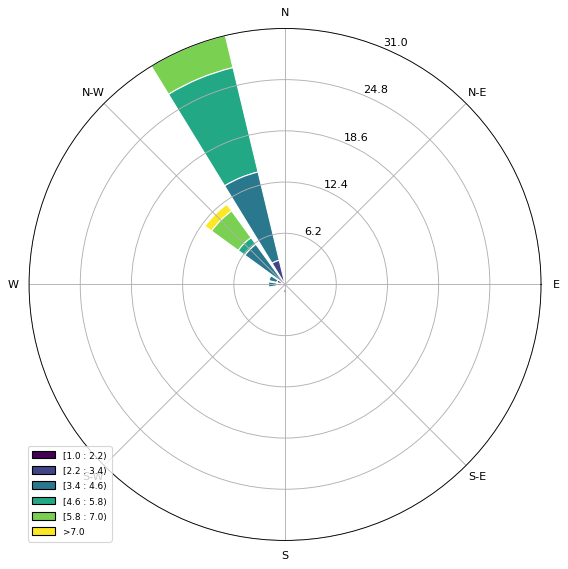

In [125]:
ax_wind = windrose.WindroseAxes.from_ax()
ax_wind.bar(wd, ws, opening=0.8, edgecolor='white')
ax_wind.set_legend()